In [1]:
import re
import requests
import pdfplumber as pp
from requests_cache import CachedSession

In [2]:


def extract_table(page):
    v_lines = (0, page.width / 2, page.width)
    table = page.extract_table({
        "explicit_vertical_lines": v_lines,
        "vertical_strategy": "explicit",
        "horizontal_strategy": "text",
        "snap_tolerance": 5,
        "intersection_tolerance": page.width,
    })
    if table:
        return table
    return []


def extract_amendments(table):
    nr = None
    start = False
    old = ''
    new = ''
    for row in table:
        if row[0].startswith('Amendement'):
            if nr and (old or new):
                yield dict(nr=nr, old=old.strip(), new=new.strip())
            try:
                nr = re.findall(r'\d+', row[0])[0]
            except:
                continue
            start = False
            old = new = ''
        elif row[1].startswith('Amendement'):
            start = True
        elif any(re.search(pattern, ''.join(row)) for pattern in (r'\d+.\d+.\d+', r'AM\\', r'PE\d{3}.\d{3}', r'\bFR\b', 'Unie dans la diversité', 'Or. en')):
            continue
        elif 'http' in row[0] or 'Justification' in ''.join(row):
            start = False
        elif start:
            old += row[0] + ' '
            new += row[1] + ' '
        else:
            continue
    return


EP_URL = 'https://www.europarl.europa.eu'


def fetch_amendments(doc):
    parts = doc.split('-')
    nr, year = parts[-1].split('/')
    if len(parts) == 3:
        url = f'https://www.europarl.europa.eu/doceo/document/RC-9-{year}-{nr}_FR.html'
    else:
        url = f'https://www.europarl.europa.eu/doceo/document/{parts[0][0]}-9-{year}-{nr}_FR.html'
    session = CachedSession()
    html = bs4.BeautifulSoup(session.get(url).content)
    amendments = []
    if amd_data := html.find(id='amdData'):
        for a in amd_data.find_all('a', attrs={'aria-label': 'pdf'}):
            pdf_url = EP_URL + a.attrs['href']
            tmp = io.BytesIO(requests.get(pdf_url).content)
            pdf = pp.open(tmp)
            for amd in extract_amendments([row for table in map(extract_table, pdf.pages) for row in table]):
                amd.update(dict(doc=doc, url=pdf_url))
                amendments.append(amd)
    return amendments

In [3]:
def extract_amendments(table):
    nr = None
    start = False
    old = ''
    new = ''
    for row in table:
        if row[0].startswith('Amendement'):
            if nr and (old or new):
                yield dict(nr=nr, old=old.strip(), new=new.strip())
            try:
                nr = re.findall(r'\d+', row[0])[0]
            except:
                continue
            start = False
            old = new = ''
        elif row[1].startswith('Amendement'):
            start = True
        elif any(re.search(pattern, ''.join(row)) for pattern in (r'\d+.\d+.\d+', r'AM\\', r'PE\d{3}.\d{3}', r'\bFR\b', 'Unie dans la diversité', 'Or. en')):
            continue
        elif 'http' in row[0] or 'Justification' in ''.join(row):
            start = False
        elif start:
            old += row[0] + ' '
            new += row[1] + ' '
        else:
            continue
    

In [4]:
import bs4
import io

EP_URL = 'https://www.europarl.europa.eu'


def fetch_amendments(doc):
    parts = doc.split('-')
    nr, year = parts[-1].split('/')
    if len(parts) == 3:
        url = f'https://www.europarl.europa.eu/doceo/document/RC-9-{year}-{nr}_FR.html'
    else:
        url = f'https://www.europarl.europa.eu/doceo/document/{parts[0][0]}-9-{year}-{nr}_FR.html'
    html = bs4.BeautifulSoup(requests.get(url).content)
    if amd_data := html.find(id='amdData'):
        for a in amd_data.find_all('a', attrs={'aria-label': 'pdf'}):
            pdf_url = EP_URL + a.attrs['href']
            tmp = io.BytesIO(requests.get(pdf_url).content)
            pdf = pp.open(tmp)
            return extract_amendments([row for table in map(extract_table, pdf.pages) for row in table])

In [5]:
import csv
from tqdm.contrib.concurrent import thread_map

docs = set()
with open('_data/votes.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    docs = set(vote['doc'] for vote in reader)

with open('_data/amendments.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['doc', 'nr', 'old', 'new', 'url'])
    writer.writeheader()
    
    amendments = [amendment for amendments in thread_map(fetch_amendments, docs) for amendment in amendments]
    writer.writerows(amendments)

  0%|          | 0/1626 [00:00<?, ?it/s]

: 

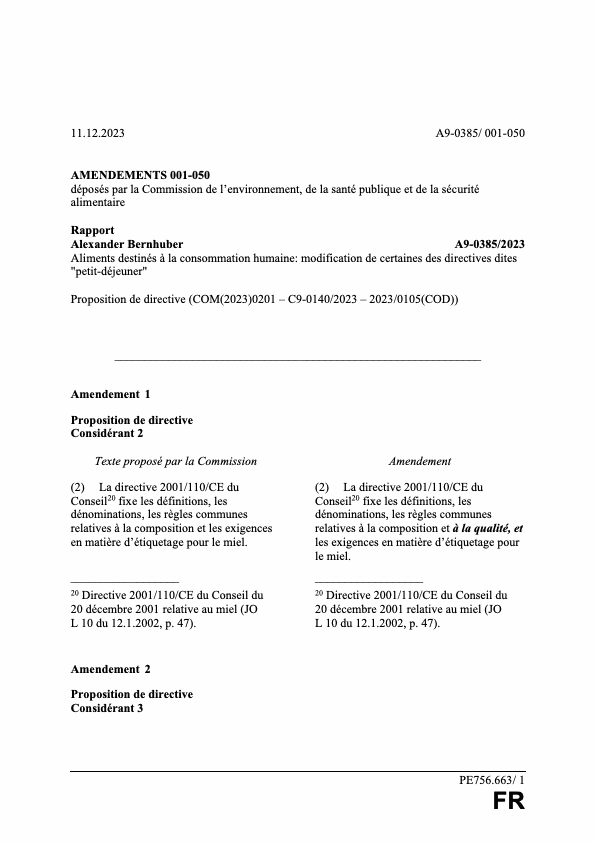

In [ ]:
page = pdf.pages[0]
page.to_image()

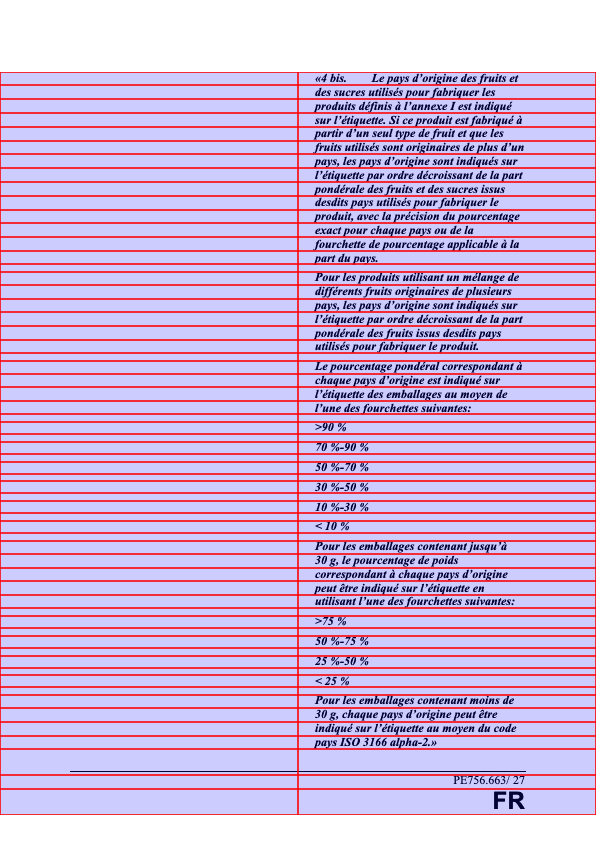

In [ ]:
page = pdf.pages[26]
v_lines = (0, page.width / 2, page.width)
table = page.find_table({
    "explicit_vertical_lines": v_lines,
    "vertical_strategy": "explicit",
    "horizontal_strategy": "text",
    "snap_tolerance": 5,
    "intersection_tolerance": page.width,
})
im = page.to_image()
im.draw_rects(table.cells)

In [19]:
import requests
import bs4

html = bs4.BeautifulSoup(requests.get('https://www.europarl.europa.eu/doceo/document/RC-9-2020-0375_FR.html').content)
html.find(string='Procédure')

'Procédure\xa0:\xa0'